# UNet for Image Segmentation

This notebook implements a UNet model for image segmentation using PyTorch. The dataset used is from the Kaggle Data Science Bowl 2018 competition, which includes images and their corresponding masks for training and testing.

[Dataset Link](https://www.kaggle.com/c/data-science-bowl-2018/data)

In [15]:
# Importing Required Libraries
import numpy as np
import os
import sys
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import jaccard_score

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = '/Users/afnanag/Desktop/CV(SOS)/UNet/stage1_train/'
TEST_PATH = '/Users/afnanag/Desktop/CV(SOS)/UNet/stage1_test/'

seed = 42
np.random.seed(seed)

In [16]:
# Function to load and resize train images and masks
def load_train_data():
    train_ids = next(os.walk(TRAIN_PATH))[1]
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        
        Y_train[n] = mask
    
    return X_train, Y_train

# Load train data
X_train, Y_train = load_train_data()

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [02:37<00:00,  4.26it/s]


In [17]:
# Function to load and resize test images
def load_test_data():
    test_ids = next(os.walk(TEST_PATH))[1]
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    
    print('Getting and resizing test images ... ')
    sys.stdout.flush()
    
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
    
    return X_test

# Load test data
X_test = load_test_data()

Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 71.04it/s]


In [18]:
# Define UNet architecture
class EncoderBlock(nn.Module):        
    def __init__(self, in_chans, out_chans, layers=2, sampling_factor=2, padding="same"):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.encoder.append(nn.Conv2d(in_chans, out_chans, 3, 1, padding=padding))
        self.encoder.append(nn.ReLU())
        for _ in range(layers-1):
            self.encoder.append(nn.Conv2d(out_chans, out_chans, 3, 1, padding=padding))
            self.encoder.append(nn.ReLU())
        self.mp = nn.MaxPool2d(sampling_factor)

    def forward(self, x):
        for enc in self.encoder:
            x = enc(x)
        mp_out = self.mp(x)
        return mp_out, x

class DecoderBlock(nn.Module):
    def __init__(self, in_chans, out_chans, layers=2, skip_connection=True, sampling_factor=2, padding="same"):
        super().__init__()
        skip_factor = 1 if skip_connection else 2
        self.decoder = nn.ModuleList()
        self.tconv = nn.ConvTranspose2d(in_chans, in_chans//2, sampling_factor, sampling_factor)
        self.decoder.append(nn.Conv2d(in_chans//skip_factor, out_chans, 3, 1, padding=padding))
        self.decoder.append(nn.ReLU())

        for _ in range(layers-1):
            self.decoder.append(nn.Conv2d(out_chans, out_chans, 3, 1, padding=padding))
            self.decoder.append(nn.ReLU())

        self.skip_connection = skip_connection
        self.padding = padding

    def forward(self, x, enc_features=None):
        x = self.tconv(x)
        if self.skip_connection:
            if self.padding != "same":
                w = x.size(-1)
                c = (enc_features.size(-1) - w) // 2
                enc_features = enc_features[:,:,c:c+w,c:c+w]
            x = torch.cat((enc_features, x), dim=1)
        for dec in self.decoder:
            x = dec(x)
        return x

class UNet(nn.Module):
    def __init__(self, nclass=1, in_chans=1, depth=5, layers=2, sampling_factor=2, skip_connection=True, padding="same"):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        out_chans = 64
        for _ in range(depth):
            self.encoder.append(EncoderBlock(in_chans, out_chans, layers, sampling_factor, padding))
            in_chans, out_chans = out_chans, out_chans*2

        out_chans = in_chans // 2
        for _ in range(depth-1):
            self.decoder.append(DecoderBlock(in_chans, out_chans, layers, skip_connection, sampling_factor, padding))
            in_chans, out_chans = out_chans, out_chans//2

        self.logits = nn.Conv2d(in_chans, nclass, 1, 1)

    def forward(self, x):
        encoded = []
        for enc in self.encoder:
            x, enc_output = enc(x)
            encoded.append(enc_output)
        x = encoded.pop()
        for dec in self.decoder:
            enc_output = encoded.pop()
            x = dec(x, enc_output)

        return self.logits(x)

In [19]:
if __name__ == "__main__":
    dtype = torch.float32
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
    print('using device:', device)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.from_numpy(X_train).permute(0, 3, 1, 2).float()
    Y_train_tensor = torch.from_numpy(Y_train).permute(0, 3, 1, 2).float()
    X_test_tensor = torch.from_numpy(X_test).permute(0, 3, 1, 2).float()

    # Create DataLoader for training data
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, Y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

using device: mps


In [20]:
# Initialize UNet model
model = UNet(in_chans=3, depth=3, layers=1, skip_connection=True)
model.to(device, dtype=dtype)

# Training parameters
lr = 1e-3
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 50
model.train()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} out of {epochs}")
    print("-" * 10)
    epoch_loss = 0.0

    for i, (X_batch, y_batch) in enumerate(tqdm(train_loader)):
        X_batch = X_batch.to(device=device, dtype=dtype)
        y_batch = y_batch.to(device=device, dtype=dtype)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss}")

Epoch 1 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.93it/s]


Epoch 1, Loss: 18.378227055072784
Epoch 2 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.91it/s]


Epoch 2, Loss: 7.431846797466278
Epoch 3 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.88it/s]


Epoch 3, Loss: 3.870157480239868
Epoch 4 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.90it/s]


Epoch 4, Loss: 4.121370531618595
Epoch 5 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.94it/s]


Epoch 5, Loss: 3.0390979200601578
Epoch 6 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.92it/s]


Epoch 6, Loss: 2.7907504066824913
Epoch 7 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.92it/s]


Epoch 7, Loss: 2.666396990418434
Epoch 8 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.97it/s]


Epoch 8, Loss: 2.487891711294651
Epoch 9 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.95it/s]


Epoch 9, Loss: 2.31363033503294
Epoch 10 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.98it/s]


Epoch 10, Loss: 2.269107259809971
Epoch 11 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.98it/s]


Epoch 11, Loss: 2.160469576716423
Epoch 12 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.93it/s]


Epoch 12, Loss: 2.1809960417449474
Epoch 13 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.93it/s]


Epoch 13, Loss: 2.29609914124012
Epoch 14 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.95it/s]


Epoch 14, Loss: 2.3436726331710815
Epoch 15 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.91it/s]


Epoch 15, Loss: 2.0097450762987137
Epoch 16 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 16, Loss: 1.9424957036972046
Epoch 17 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 17, Loss: 1.9591215923428535
Epoch 18 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.93it/s]


Epoch 18, Loss: 1.9061028137803078
Epoch 19 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 19, Loss: 1.816984087228775
Epoch 20 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 20, Loss: 1.7842908762395382
Epoch 21 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 21, Loss: 1.9944811575114727
Epoch 22 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 22, Loss: 1.946810208261013
Epoch 23 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.96it/s]


Epoch 23, Loss: 1.8883091285824776
Epoch 24 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.96it/s]


Epoch 24, Loss: 1.8518915921449661
Epoch 25 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.92it/s]


Epoch 25, Loss: 1.7383806258440018
Epoch 26 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.83it/s]


Epoch 26, Loss: 1.7155928499996662
Epoch 27 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 27, Loss: 1.7438919618725777
Epoch 28 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 28, Loss: 1.9390991926193237
Epoch 29 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 29, Loss: 1.7241769321262836
Epoch 30 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 30, Loss: 1.6597600989043713
Epoch 31 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.98it/s]


Epoch 31, Loss: 1.6291603446006775
Epoch 32 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 32, Loss: 1.6129196658730507
Epoch 33 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 33, Loss: 1.6361498534679413
Epoch 34 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 34, Loss: 1.6415959410369396
Epoch 35 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 35, Loss: 1.6437583789229393
Epoch 36 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 36, Loss: 1.6224760115146637
Epoch 37 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 37, Loss: 1.5534669272601604
Epoch 38 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 38, Loss: 1.5601939484477043
Epoch 39 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 39, Loss: 1.6113524287939072
Epoch 40 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 40, Loss: 1.71933488920331
Epoch 41 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 41, Loss: 1.6770394928753376
Epoch 42 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 42, Loss: 1.5823166519403458
Epoch 43 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 43, Loss: 1.5666681677103043
Epoch 44 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 44, Loss: 1.5177882947027683
Epoch 45 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 45, Loss: 1.5040428526699543
Epoch 46 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 46, Loss: 1.4959516003727913
Epoch 47 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  2.99it/s]


Epoch 47, Loss: 1.4652653001248837
Epoch 48 out of 50
----------


100%|██████████| 21/21 [00:06<00:00,  3.00it/s]


Epoch 48, Loss: 1.561435591429472
Epoch 49 out of 50
----------


100%|██████████| 21/21 [00:07<00:00,  3.00it/s]


Epoch 49, Loss: 1.538049466907978
Epoch 50 out of 50
----------


100%|██████████| 21/21 [00:06<00:00,  3.00it/s]

Epoch 50, Loss: 1.5699077807366848


100%|██████████| 65/65 [00:00<00:00, 175.47it/s]


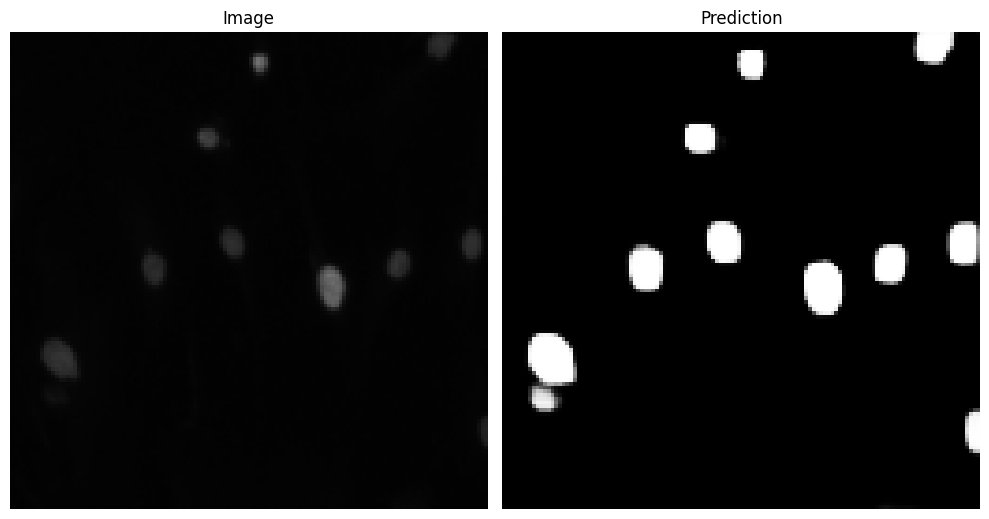

In [41]:
# Evaluation
model.eval()
with torch.no_grad():
    predictions = []
    for i, X_test_batch in enumerate(tqdm(X_test_tensor)):
        X_test_batch = X_test_batch.unsqueeze(0).to(device=device, dtype=dtype)
        pred = model(X_test_batch)
        pred = torch.sigmoid(pred)
        pred = pred.cpu().numpy().squeeze()
        predictions.append(pred)

# Visualize a single prediction
index = 0  # Index of the image you want to visualize
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(X_test[index])
plt.title('Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predictions[index], cmap='gray')
plt.title('Prediction')
plt.axis('off')

plt.tight_layout()
plt.show()